# <img src="./assets/icons/nn.png" style="height:50px;display:inline"> ECE 045107 - Technion - Deep Learning Lab
---

#### Written by <a href="https://taldatech.github.io">Tal Daniel</a>

## <img src="./assets/icons/lab.png" style="height:50px;display:inline"> Lab Part 2 - Self-Supervised & Representation Learning
---

## <img src="./assets/icons/experiment.png" style="height:50px;display:inline"> Experiment
---

### <img src="./assets/icons/information.png" style="height:50px;display:inline"> Students Information
---
* Fill in

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Aviv Shem-Tov| avivst@campus.technion.ac.il| 205873987|
|Izar Hasson | izar_hasson1@campus.technion.ac.il| 318739240|


### <img src="./assets/icons/keyboard.png" style="height:50px;display:inline"> Keyboard Shortcuts
---
* Run current cell: **Ctrl + Enter**
* Run current cell and move to the next: **Shift + Enter**
* Show lines in a code cell: **Esc + L**
* View function documentation: **Shift + Tab** inside the parenthesis or `help(name_of_module)`
* New cell below: **Esc + B**
* Delete cell: **Esc + D, D** (two D's)

### <img src="./assets/icons/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
* Maximal garde: 100.
* Submission only in **pairs**. 
* **No handwritten submissions.** You can choose whether to answer in a Markdown cell in this notebook or attach a PDF with your answers.
* <a style='color:red'> SAVE THE NOTEBOOKS WITH THE OUTPUT, CODE CELLS THAT WERE NOT RUN WILL NOT GET ANY POINTS! </a>
* What you have to submit:
    * If you have answered the questions in the notebook, you should submit this file only, with the name: `045107_dl_lab_ssl_exp_id1_id2.ipynb`.
    * If you answered the questionss in a different file you should submit a `.zip` file with the name `045107_dl_lab_ssl_exp_id1_id2.zip` with content:
        * `045107_dl_lab_ssl_exp_id1_id2.ipynb` - the code tasks
        * `045107_dl_lab_ssl_exp_id1_id2.pdf` - answers to questions.
    * No other file-types (`.py`, `.docx`...) will be accepted.
* **Latex in Colab** - in some cases, Latex equations may no be rendered. To avoid this, make sure to not use *bullets* in your answers ("* some text here with Latex equations" -> "some text here with Latex equations").

### <img src="./assets/icons/online.png" style="height:50px;display:inline"> Working Online and Locally
---
* You can choose your working environment:
    1. `Jupyter Notebook`, **locally** with <a href="https://www.anaconda.com/download">Anaconda</a> or **online** on <a href="https://colab.research.google.com/">Google Colab</a>
        * Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime`$\rightarrow$ `Change Runtime Type` $\rightarrow$`GPU`.
    2. Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both allow editing and running Jupyter Notebooks.

* You can choose whether to answser these straight in the notebook (Markdown + Latex) or use another editor (Word, LyX, Latex, Overleaf...) and submit an additional PDF file, **but no handwritten submissions**.
* You can attach additional figures (drawings, graphs,...) in a separate PDF file, just make sure to refer to them in your answers.

* $\large\LaTeX$ <a href="https://kapeli.com/cheat_sheets/LaTeX_Math_Symbols.docset/Contents/Resources/Documents/index">Cheat-Sheet</a> (to write equations)
    * <a href="http://tug.ctan.org/info/latex-refsheet/LaTeX_RefSheet.pdf">Another Cheat-Sheet</a>

### <img src="./assets/icons/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Task 1 - Loading the Data and Applying Data Augmentations](#-Task-1---Loading-the-Data-and-Applying-Data-Augmentations)
* [Task 2 - Momentum Network - Exponential Moving Average](#-Task-2---Momentum-Network----Exponential-Moving-Average)
* [Task 3 - Building the BYOL Model](#-Task-3---Building-the-BYOL-Model)
* [Task 4 - Loss Functions and Hyper-parameters](#-Task-4---Loss-Functions-and-Hyper-parameters)
* [Task 5 - Training the Model](#-Task-5---Training-the-Model)
* [Task 6 - Probing the Model](#-Task-6---Probing-the-Model)
* [Task 7 - Using the Model for Linear Classification](#-Task-7---Using-the-Model-for-Linear-Classification)
* [Credits](#-Credits)

In [1]:
# imports for the lab
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from helper_functions import *
from tqdm import tqdm
# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as T
from torchvision.transforms import functional as TF
import torchvision
from torch.nn.functional import cosine_similarity

# scikit-learn imports
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

**Experiment Code Tasks**: complete the missing code lines marked with `# TODO`.

**Experiment Questions**: in the final report, you need to answer questions and provide figures.

Questions that are marked with a **bold** font, can be answered during models training so you can asnwer them later. 

Questions that are marked with an *italic* font, should be answered before models training as they are required for your understanding. 

**TO SAVE TIME, ANSWER THE QUESTIONS DURING MODEL TRAINING** (not before).

## <img src="./assets/icons/code.png" style="height:50px;display:inline"> Task 1 - Loading the Data and Applying Data Augmentations
---
1. In this section of the lab we are going to work with the <a href="https://cs.stanford.edu/~acoates/stl10/">**STL-10**</a> dataset which is available to download and load with <a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.STL10.html#torchvision.datasets.STL10">`torchvision.datasets.STL10`</a>. The dataset includes $96\times 96$ RGB images from 10 classes (very similar to CIFAR-10) where there are 500 training images and 800 test images per class, and **100,000 unlabeled images**.
    * **Question 1.1**: Why can we assume that supervised learning of a deep (convolutional) neural network would not result in a good performance (i.e., high accuracy) on the STL-10 dataset? Why is it a good fit for self-supervised learning?
2. For self-supervised learning, we need to create poistive pairs. The common paradigm for image representation learning with self-supervised learning is using augmented views of the same image as positive pairs.
    * **Question 1.2**: Briefly explain the following <a href="https://pytorch.org/vision/stable/transforms.html">`torchvision` transformations</a>: `RandomCrop`, `ColorJitter`, `RandomGrayscale`, `RandomHorizontalFlip`, `RandomPerspective`, `RandomRotation`, `RandomInvert`.
    * **Question 1.3**: For the **STL-10**, which of the above augmentations are "safe" to apply without changing the image label? 
3. To intergrate augementations in our dataset, there are usually 3 approaches:
    * Modifying the `Dataset` class such that `__getitem__(self, index)` returns 2 augmented views of the same image. The adavantage of this approach is that it usually simpler and most `torchvision` datasets support it via the `transforms` parameter input.
    * Implementing "Collate Function" - `collate_fn` that implements the augmentations and is passed directly to the `DataLoader` class (instead of inside the `Dataset` class). The advantage of this approach is that it is dataset-agnostic and does not require modifying the `Dataset` class.
    * Applying augementations directly on the tensor batch using libaries like <a href="https://kornia.github.io">`kornia`</a> inside the training loop. The advantage of this approach is that augmentations can be performed directly on the GPU, making the process much faster, and making the augmentation process differentiable in some cases (i.e., `loss.backwards()` will propagate gradients throguh the augmentation function).
    
    Here, we will use the second approch - implementing a collate function. Inspect and explain what `ImageCollateFunction` is doing. Load the training data (unlabeled + training data) of the **STL-10** dataset with at least 3 image augmenations of your choosing and display 5 images from the dataset (with the augmentations applied).
4. Create a `DataLoader` for the `Dataset` from the previous section. If you are using a GPU-powered machine, use `num_workers` $>1$ to speed-up the data transfer to the GPU. Set `shuffle=True` and briefly explain why.
    * *Question 1.4*: Pick the `batch_size`, explain what are the considerations for tuning this hyper-parameter in self-supervised learning.
    * *Question 1.5*: What are the contents of each batch? To get an examplary batch use `batch = next(iter(dataloader))`.
5. Plot 5 images from the loaded data with `matplotlib`.

### Note: it takes a while to download the STL-10 data, need to make sure the data is on the disk before the experiment.

In [2]:
# download/load the data, create a dataloader
stl10 = torchvision.datasets.STL10("./datasets/stl10", download=True, split="train+unlabeled")
# splits: One of {‘train’, ‘test’, ‘unlabeled’, ‘train+unlabeled’}. Accordingly dataset is selected.

# stl-10 includes 96x96 resolution iamges, to save time, we will work with 64x64
# the collate function includes all of the image AUGMENTATIONS, take a look in helper_functions.py
image_size = 64
collate_fn = ImageCollateFunction(input_size=image_size)  # input_size = image_size

# lets' load the data, we will work with batch_size=256 throughout this lab
dataloader = DataLoader(
    stl10,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=4,
)

Files already downloaded and verified


In [3]:
# get a batch
batch = next(iter(dataloader))

In [4]:
# observe the batch contents
print(len(batch))
print(len(batch[0][0]), len(batch[0][1]))
print(len(batch[1]))
# let's look at the content
print(batch[0][0].shape)
print(batch[0][1].shape)
print(batch[1].shape)
# labels
print(batch[1][:5])

2
256 256
256
torch.Size([256, 3, 64, 64])
torch.Size([256, 3, 64, 64])
torch.Size([256])
tensor([-1, -1, -1, -1, -1])


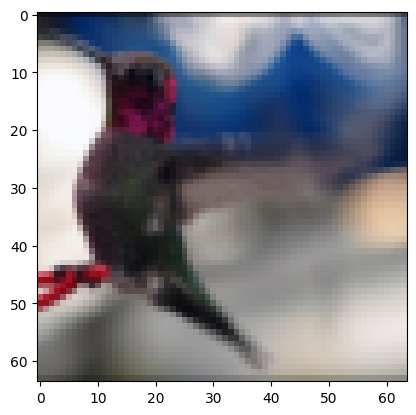

In [34]:
# plot images
def to_rgb(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # imagenet normalized image -> rgb
    mean = torch.tensor(mean, device=x.device)[None, :, None, None]  # shape: [1, 3, 1, 1]
    std = torch.tensor(std, device=x.device)[None, :, None, None]  # shape: [1, 3, 1, 1]
    return (x * std) + mean

images = to_rgb(batch[0][0])

# TODO: plot 5 images with matplotlib
images_to_plot = images.permute(0,2,3,1).data.cpu().numpy()[0:5]
for image in images_to_plot:
    plt.figure()
    plt.imshow(image)
# plt.imshow(images.permute(0,2,3,1).data.cpu().numpy()[0:5])

## <img src="./assets/icons/code.png" style="height:50px;display:inline"> Task 2 - Momentum Network -  Exponential Moving Average
---
A recent trend in deep learning is using a momentum network to stabilize the training process and improve the final performance of the model. The momentum network has the exact architecture of the original model, but its gradients are turned off and its parameters are updated with exponential moving average (EMA).

1. Create a simple dummy 2-layer MLP `mlp`. You are free to choose the number of hidden units and the activations. You will only use this network to test specific functions, and you are not going to train it.
2. Create the momentum version `momentum_mlp` by using `copy.deepcopy()` to copy `mlp`, and turn off its gradients.
3. Implement a function `momentum_update(momentum_params, new_params, m=0.999)` the updates the momentum network parameters according to the EMA update rule. Validate that it works by using `mlp` and `momentum_mlp` by observing the weights before and after the updates (no need to print all of the weights, you can pick one layer). We also re-initailzie the weights of `mlp` after the `copy.deepcopy()` line to ensure `mlp` has different weight values, to observe the effect of the update.
    * To perform the update, you need to directly assign the field `param.data` with the new value.
    * Decorate the function with `@torch.no_grad()` to make sure gradients are not recorded.
    * **Question 2.1**: What is the role of `m`?

In [6]:
mlp = nn.Sequential(
    nn.Linear(4096,100),
    nn.LeakyReLU(),
    nn.Linear(100,10)
)

momentum_mlp = copy.deepcopy(mlp)
momentum_mlp.requires_grad_(False)
# re-initailize the mlp to ensure it has different weights
for m in mlp:
    if isinstance(m, nn.Linear):
        m.reset_parameters()

In [7]:
# implement the momentum update function
# momentum_param = m * momentum_param + (1 - m) * param
@torch.no_grad()
def momentum_update(momentum_params, new_params, m=0.999):
    """Updates the weights of the previous parameters.
    """
    for momentum_param, param in zip(momentum_params, new_params):
        momentum_param.data = m * momentum_param.data + (1. - m) * param.data

In [8]:
# check the function
print(f'before momentum update:')
print(momentum_mlp[0].weight.data[0])
print(f'---------------')
momentum_update(momentum_mlp.parameters(), mlp.parameters(), m=0.99)
print(f'after momentum update:')
print(momentum_mlp[0].weight.data[0])

before momentum update:
tensor([ 0.0125,  0.0103,  0.0095,  ..., -0.0104,  0.0058, -0.0075])
---------------
after momentum update:
tensor([ 0.0124,  0.0102,  0.0095,  ..., -0.0102,  0.0056, -0.0075])


## <img src="./assets/icons/code.png" style="height:50px;display:inline"> Task 3 - Building the BYOL Model
---

* In the following task we are going to implement the BYOL model.
* We will use the `ResNet18` architecture as our backbone to process images with a CNN.
* The projection and prediction networks are going to have the same MLP architecture: `Linear, BatchNorm, ReLU, Linear`, where the `BatchNorm` will be optional (in PyTorch, layers can be replaced with `nn.Identity()` to do nothing to the input).
* Complete the lines marked with `# TODO`.
* **Question 3.1**: Why is the `forward()` (not `_forward()`) function of our model accepts two inputs `x0` and `x1`?

In [9]:
# complete the functions and model
def _get_byol_mlp(num_ftrs: int, hidden_dim: int, out_dim: int, batch_norm: bool):
    """Returns a 2-layer MLP with batch norm on the hidden layer.
    Reference (12.03.2021)
    https://arxiv.org/abs/2006.07733
    """
    modules = [
        nn.Linear(num_ftrs, hidden_dim),
        nn.BatchNorm1d(hidden_dim) if batch_norm else nn.Identity(),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim),
    ]
    return nn.Sequential(*modules)


class BYOL(nn.Module):
    """Implementation of the BYOL architecture.
    Attributes:
        backbone:
            Backbone model to extract features from images.
        num_ftrs:
            Dimension of the embedding (before the projection mlp).
        hidden_dim:
            Dimension of the hidden layer in the projection and prediction mlp.
        out_dim:
            Dimension of the output (after the projection/prediction mlp).
        m:
            Momentum for the momentum update of encoder.
        batch_norm:
            flag to use batch normalization in the architecture
    """

    def __init__(
        self,
        backbone: nn.Module,
        num_ftrs: int = 2048,
        hidden_dim: int = 4096,
        out_dim: int = 256,
        batch_norm: bool = True
    ):

        super(BYOL, self).__init__()

        self.backbone = backbone
        # the architecture of the projection and prediction head is the same
        # use _get_byol_mlp() to implement the projection and prediction heads - read the doc above
        self.projection_head = _get_byol_mlp(num_ftrs, hidden_dim, out_dim, batch_norm)
        self.prediction_head = _get_byol_mlp(out_dim, hidden_dim, out_dim, batch_norm)
        self.momentum_backbone = None
        self.momentum_projection_head = None
        self.relu = nn.ReLU()
        self._init_momentum_encoder()

        
    def _init_momentum_encoder(self):
        """Initializes momentum backbone and a momentum projection head.
        """
        assert self.backbone is not None
        assert self.projection_head is not None

        self.momentum_backbone = copy.deepcopy(self.backbone)
        self.momentum_projection_head = copy.deepcopy(self.projection_head)

        self.momentum_backbone.requires_grad_(False)
        self.momentum_projection_head.requires_grad_(False)

    def _forward(self, x0: torch.Tensor, x1: torch.Tensor = None):
        """Forward pass through the encoder and the momentum encoder.
        Performs the momentum update, extracts features with the backbone and
        applies the projection (and prediciton) head to the output space. If
        x1 is None, only x0 will be processed otherwise, x0 is processed with
        the encoder and x1 with the momentum encoder.
        Args:
            x0:
                Tensor of shape bsz x channels x W x H.
            x1:
                Tensor of shape bsz x channels x W x H.
        Returns:
            The output proejction of x0 and (if x1 is not None) the output
            projection of x1.
        Examples:
            >>> # single input, single output
            >>> out = model._forward(x)
            >>>
            >>> # two inputs, two outputs
            >>> out0, out1 = model._forward(x0, x1)
        """

        # forward pass of first input x0
        f0 = self.backbone(x0).flatten(start_dim=1)
        z0 = self.projection_head(f0)
        out0 = self.prediction_head(z0)

        if x1 is None:
            return out0

        # forward pass of second input x1
        with torch.no_grad():

            f1 = self.momentum_backbone(x1).flatten(start_dim=1)
            out1 = self.momentum_projection_head(f1)

        return out0, out1

    def forward(
        self, x0: torch.Tensor, x1: torch.Tensor
    ):
        """Symmetrizes the forward pass (see _forward).
        Performs two forward passes, once where x0 is passed through the encoder
        and x1 through the momentum encoder and once the other way around.
        Note that this model currently requires two inputs for the forward pass
        (x0 and x1).
        Args:
            x0:
                Tensor of shape bsz x channels x W x H.
            x1:
                Tensor of shape bsz x channels x W x H.
        Returns:
            A tuple out0, out1, where out0 and out1 are tuples containing the
            predictions and projections of x0 and x1: out0 = (z0, p0) and
            out1 = (z1, p1).
        """

        if x0 is None:
            raise ValueError("x0 must not be None!")
        if x1 is None:
            raise ValueError("x1 must not be None!")

        if not all([s0 == s1 for s0, s1 in zip(x0.shape, x1.shape)]):
            raise ValueError(
                f"x0 and x1 must have same shape but got shapes {x0.shape} and {x1.shape}!"
            )

        p0, z1 = self._forward(x0, x1)
        p1, z0 = self._forward(x1, x0)

        return (z0, p0), (z1, p1)

## <img src="./assets/icons/code.png" style="height:50px;display:inline"> Task 4 - Loss Functions and Hyper-parameters
---
* Define the hyper-parameters of the model. Note that self-supervised learning usually require a lot of epochs ($>800$), but since we have limited time, we will train for a maximal number of $120$ epochs.

In [10]:
class NegativeCosineSimilarity(torch.nn.Module):
    """Implementation of the Negative Cosine Simililarity used in the SimSiam[0] paper.
    [0] SimSiam, 2020, https://arxiv.org/abs/2011.10566
    Examples:
        >>> # initialize loss function
        >>> loss_fn = NegativeCosineSimilarity()
        >>>
        >>> # generate two representation tensors
        >>> # with batch size 10 and dimension 128
        >>> x0 = torch.randn(10, 128)
        >>> x1 = torch.randn(10, 128)
        >>>
        >>> # calculate loss
        >>> loss = loss_fn(x0, x1)
    """

    def __init__(self, dim: int = 1, eps: float = 1e-8) -> None:
        """Same parameters as in torch.nn.CosineSimilarity
        Args:
            dim (int, optional):
                Dimension where cosine similarity is computed. Default: 1
            eps (float, optional):
                Small value to avoid division by zero. Default: 1e-8
        """
        super().__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x0: torch.Tensor, x1: torch.Tensor) -> torch.Tensor:
        return - cosine_similarity(x0, x1, self.dim, self.eps).mean() # TODO, use cosine_similarity() to implement the return value. use `.mean()` to return the batch mean

In [11]:
# pick hyper-paramteres
lr = 3e-4 # TODO, values should be in [1e-4, 1e-4]
criterion = NegativeCosineSimilarity()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 100
hidden_dim = 2048
out_dim = 256
m = 0.9 # TODO, `m` is the momentum value
use_pretrianed = False  # flag to load pre-trained ImageNet backbone weights, will use later
run_name = f'byol_cosine_pretrained_{use_pretrianed}'

## <img src="./assets/icons/code.png" style="height:50px;display:inline"> Task 5 - Training the Model
---
* Train with Negative Cosine Similarity as the loss function and **save** the model for $120$ epochs.
    * **Question 5.1**: Why are we optimizing the *negative* cosine similarity and not the positive?
* Train a second model **with pre-trained ImageNet weights for the backbone** for $40$ epochs. **Make sure to change `run_name` to something else so your model will no be overwritten**. You should have 2 models checkpoints saved.
    * Note the ImageNet is a different dataset than STL-10, so this why we still need to re-traine the network.
    * **Question 5.2**: Why can we assume that we can train for less epochs when we use a pre-trained backbone? What other hyper-parameter we should consider when using a pre-trained backbone? (Hint: think about fine-tuning).
    * This is similar to fine-tuning, but with a self-supervised objective.
    * Hyper-parameters for this training should be picked again.

In [12]:
def save_checkpoint(model, optimizer, epoch=None, save_dir='./'):
    data = {
        'epoch': epoch,
        'model': model.state_dict(),
        'opt': optimizer.state_dict()
    }

    torch.save(data, os.path.join(save_dir, 'model.pth'))

def load_from_checkpoint(model, optimizer, device, save_dir='./'):
    # model_path = str(save_dir / f'model.pth')
    model_path = os.path.join(save_dir, 'model.pth')
    if not os.path.exists(model_path):
        print(f'model checkpoint not found, training from scratch')
        return 0
    data = torch.load(model_path, map_location=device)
    model.load_state_dict(data['model'])
    epoch = data['epoch']
    optimizer.load_state_dict(data['opt'])
    print(f'loaded model from checkpoint, resuming training from epoch {epoch}')
    return epoch

### BYOL - Training from Scratch
---

In [13]:
save_dir = os.path.join('./', run_name)
os.makedirs(save_dir, exist_ok=True)
use_pretrained = False
pretrained_weights = torchvision.models.ResNet18_Weights.DEFAULT if use_pretrained else None
resnet = torchvision.models.resnet18(weights=pretrained_weights)
backbone = nn.Sequential(*list(resnet.children())[:-1])
num_ftrs = backbone(torch.rand(1, 3, image_size, image_size)).view(-1).shape[-1]
print(f'output features from backbone: {num_ftrs}')
# initialize the BYOL() model
model = BYOL(backbone, num_ftrs=num_ftrs, hidden_dim=hidden_dim, out_dim=out_dim, batch_norm=True)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler is used only if you train for at least 300 epcochs
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 350, 380], gamma=0.1, verbose=True)
start_epoch = load_from_checkpoint(model, optimizer, device, save_dir=save_dir)

print("Starting Training")
for epoch in range(start_epoch, epochs):
    total_loss = 0
    pbar = tqdm(iterable=dataloader)
    for (x0, x1), _ in pbar:
        momentum_update(momentum_params=model.momentum_backbone.parameters(), new_params=model.backbone.parameters(), m=m)
        # update momentum of the projection head (model.projection_head.parameters())
        momentum_update(momentum_params=model.momentum_projection_head.parameters(), new_params=model.projection_head.parameters(), m=m) # TODO
        x0 = x0.to(device)
        x1 = x1.to(device)
        (z0, p0), (z1, p1) = model(x0, x1)
        # calculate loss for both sides
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))  # TODO
        total_loss += loss.detach()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # progress bar
        pbar.set_description_str(f'epoch #{epoch}')
        pbar.set_postfix(loss=loss.data.cpu().item())
    pbar.close()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch}, loss: {avg_loss:.5f}")
    scheduler.step()
    save_checkpoint(model, optimizer, epoch, save_dir)

output features from backbone: 512


/home/dl_exp/Desktop/Deep Learning experiment/Meeting 2/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


model checkpoint not found, training from scratch
Starting Training


epoch #0: 100%|██████████| 410/410 [00:45<00:00,  9.00it/s, loss=-0.732]


epoch: 0, loss: -0.75240


epoch #1: 100%|██████████| 410/410 [00:45<00:00,  9.08it/s, loss=-0.856]


epoch: 1, loss: -0.83862


epoch #2: 100%|██████████| 410/410 [00:45<00:00,  9.09it/s, loss=-0.879]


epoch: 2, loss: -0.86838


epoch #3: 100%|██████████| 410/410 [00:44<00:00,  9.25it/s, loss=-0.863]


epoch: 3, loss: -0.87186


epoch #4: 100%|██████████| 410/410 [00:44<00:00,  9.30it/s, loss=-0.892]


epoch: 4, loss: -0.87654


epoch #5: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.884]


epoch: 5, loss: -0.88146


epoch #6: 100%|██████████| 410/410 [00:44<00:00,  9.27it/s, loss=-0.897]


epoch: 6, loss: -0.88736


epoch #7: 100%|██████████| 410/410 [00:44<00:00,  9.18it/s, loss=-0.883]


epoch: 7, loss: -0.88949


epoch #8: 100%|██████████| 410/410 [00:44<00:00,  9.20it/s, loss=-0.887]


epoch: 8, loss: -0.89446


epoch #9: 100%|██████████| 410/410 [00:43<00:00,  9.35it/s, loss=-0.904]


epoch: 9, loss: -0.89648


epoch #10: 100%|██████████| 410/410 [00:44<00:00,  9.27it/s, loss=-0.899]


epoch: 10, loss: -0.89826


epoch #11: 100%|██████████| 410/410 [00:44<00:00,  9.24it/s, loss=-0.909]


epoch: 11, loss: -0.90032


epoch #12: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.914]


epoch: 12, loss: -0.90270


epoch #13: 100%|██████████| 410/410 [00:45<00:00,  9.08it/s, loss=-0.907]


epoch: 13, loss: -0.90438


epoch #14: 100%|██████████| 410/410 [00:44<00:00,  9.25it/s, loss=-0.92] 


epoch: 14, loss: -0.90577


epoch #15: 100%|██████████| 410/410 [00:44<00:00,  9.16it/s, loss=-0.9]  


epoch: 15, loss: -0.90597


epoch #16: 100%|██████████| 410/410 [00:44<00:00,  9.19it/s, loss=-0.9]  


epoch: 16, loss: -0.90793


epoch #17: 100%|██████████| 410/410 [00:44<00:00,  9.13it/s, loss=-0.908]


epoch: 17, loss: -0.90849


epoch #18: 100%|██████████| 410/410 [00:44<00:00,  9.18it/s, loss=-0.919]


epoch: 18, loss: -0.91053


epoch #19: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.907]


epoch: 19, loss: -0.91088


epoch #20: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.898]


epoch: 20, loss: -0.91159


epoch #21: 100%|██████████| 410/410 [00:45<00:00,  9.06it/s, loss=-0.919]


epoch: 21, loss: -0.91223


epoch #22: 100%|██████████| 410/410 [00:45<00:00,  9.07it/s, loss=-0.916]


epoch: 22, loss: -0.91235


epoch #23: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.904]


epoch: 23, loss: -0.91411


epoch #24: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.914]


epoch: 24, loss: -0.91445


epoch #25: 100%|██████████| 410/410 [00:43<00:00,  9.33it/s, loss=-0.913]


epoch: 25, loss: -0.91524


epoch #26: 100%|██████████| 410/410 [00:43<00:00,  9.36it/s, loss=-0.928]


epoch: 26, loss: -0.91629


epoch #27: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.919]


epoch: 27, loss: -0.91663


epoch #28: 100%|██████████| 410/410 [00:43<00:00,  9.34it/s, loss=-0.913]


epoch: 28, loss: -0.91788


epoch #29: 100%|██████████| 410/410 [00:43<00:00,  9.36it/s, loss=-0.92] 


epoch: 29, loss: -0.91835


epoch #30: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.914]


epoch: 30, loss: -0.91826


epoch #31: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.922]


epoch: 31, loss: -0.91899


epoch #32: 100%|██████████| 410/410 [00:43<00:00,  9.35it/s, loss=-0.919]


epoch: 32, loss: -0.91928


epoch #33: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.912]


epoch: 33, loss: -0.91875


epoch #34: 100%|██████████| 410/410 [00:44<00:00,  9.28it/s, loss=-0.916]


epoch: 34, loss: -0.91945


epoch #35: 100%|██████████| 410/410 [00:44<00:00,  9.31it/s, loss=-0.917]


epoch: 35, loss: -0.92013


epoch #36: 100%|██████████| 410/410 [00:44<00:00,  9.15it/s, loss=-0.922]


epoch: 36, loss: -0.91935


epoch #37: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.92] 


epoch: 37, loss: -0.91979


epoch #38: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.922]


epoch: 38, loss: -0.92046


epoch #39: 100%|██████████| 410/410 [00:44<00:00,  9.19it/s, loss=-0.923]


epoch: 39, loss: -0.92110


epoch #40: 100%|██████████| 410/410 [00:44<00:00,  9.16it/s, loss=-0.93] 


epoch: 40, loss: -0.92198


epoch #41: 100%|██████████| 410/410 [00:44<00:00,  9.29it/s, loss=-0.919]


epoch: 41, loss: -0.92137


epoch #42: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.926]


epoch: 42, loss: -0.92124


epoch #43: 100%|██████████| 410/410 [00:44<00:00,  9.18it/s, loss=-0.921]


epoch: 43, loss: -0.92127


epoch #44: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.927]


epoch: 44, loss: -0.92081


epoch #45: 100%|██████████| 410/410 [00:44<00:00,  9.13it/s, loss=-0.928]


epoch: 45, loss: -0.92238


epoch #46: 100%|██████████| 410/410 [00:44<00:00,  9.30it/s, loss=-0.923]


epoch: 46, loss: -0.92268


epoch #47: 100%|██████████| 410/410 [00:44<00:00,  9.20it/s, loss=-0.915]


epoch: 47, loss: -0.92204


epoch #48: 100%|██████████| 410/410 [00:44<00:00,  9.20it/s, loss=-0.921]


epoch: 48, loss: -0.92247


epoch #49: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.934]


epoch: 49, loss: -0.92293


epoch #50: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.923]


epoch: 50, loss: -0.92299


epoch #51: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.924]


epoch: 51, loss: -0.92176


epoch #52: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.919]


epoch: 52, loss: -0.92179


epoch #53: 100%|██████████| 410/410 [00:44<00:00,  9.26it/s, loss=-0.907]


epoch: 53, loss: -0.92266


epoch #54: 100%|██████████| 410/410 [00:44<00:00,  9.28it/s, loss=-0.925]


epoch: 54, loss: -0.92249


epoch #55: 100%|██████████| 410/410 [00:44<00:00,  9.18it/s, loss=-0.929]


epoch: 55, loss: -0.92296


epoch #56: 100%|██████████| 410/410 [00:44<00:00,  9.13it/s, loss=-0.914]


epoch: 56, loss: -0.92302


epoch #57: 100%|██████████| 410/410 [00:44<00:00,  9.29it/s, loss=-0.925]


epoch: 57, loss: -0.92303


epoch #58: 100%|██████████| 410/410 [00:44<00:00,  9.24it/s, loss=-0.93] 


epoch: 58, loss: -0.92323


epoch #59: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.925]


epoch: 59, loss: -0.92261


epoch #60: 100%|██████████| 410/410 [00:44<00:00,  9.25it/s, loss=-0.922]


epoch: 60, loss: -0.92232


epoch #61: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.928]


epoch: 61, loss: -0.92246


epoch #62: 100%|██████████| 410/410 [00:44<00:00,  9.24it/s, loss=-0.925]


epoch: 62, loss: -0.92171


epoch #63: 100%|██████████| 410/410 [00:43<00:00,  9.32it/s, loss=-0.93] 


epoch: 63, loss: -0.92139


epoch #64: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.919]


epoch: 64, loss: -0.92140


epoch #65: 100%|██████████| 410/410 [00:44<00:00,  9.31it/s, loss=-0.929]


epoch: 65, loss: -0.92118


epoch #66: 100%|██████████| 410/410 [00:44<00:00,  9.20it/s, loss=-0.912]


epoch: 66, loss: -0.92123


epoch #67: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.926]


epoch: 67, loss: -0.92171


epoch #68: 100%|██████████| 410/410 [00:44<00:00,  9.29it/s, loss=-0.918]


epoch: 68, loss: -0.92165


epoch #69: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.917]


epoch: 69, loss: -0.92133


epoch #70: 100%|██████████| 410/410 [00:44<00:00,  9.19it/s, loss=-0.917]


epoch: 70, loss: -0.92156


epoch #71: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.919]


epoch: 71, loss: -0.92176


epoch #72: 100%|██████████| 410/410 [00:44<00:00,  9.27it/s, loss=-0.917]


epoch: 72, loss: -0.92047


epoch #73: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.928]


epoch: 73, loss: -0.92079


epoch #74: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.91] 


epoch: 74, loss: -0.92128


epoch #75: 100%|██████████| 410/410 [00:44<00:00,  9.16it/s, loss=-0.93] 


epoch: 75, loss: -0.92034


epoch #76: 100%|██████████| 410/410 [00:44<00:00,  9.15it/s, loss=-0.921]


epoch: 76, loss: -0.92113


epoch #77: 100%|██████████| 410/410 [00:45<00:00,  9.10it/s, loss=-0.921]


epoch: 77, loss: -0.92034


epoch #78: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.92] 


epoch: 78, loss: -0.92008


epoch #79: 100%|██████████| 410/410 [00:44<00:00,  9.15it/s, loss=-0.92] 


epoch: 79, loss: -0.92062


epoch #80: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.924]


epoch: 80, loss: -0.92056


epoch #81: 100%|██████████| 410/410 [00:45<00:00,  9.10it/s, loss=-0.925]


epoch: 81, loss: -0.92058


epoch #82: 100%|██████████| 410/410 [00:44<00:00,  9.12it/s, loss=-0.914]


epoch: 82, loss: -0.92034


epoch #83: 100%|██████████| 410/410 [00:44<00:00,  9.15it/s, loss=-0.918]


epoch: 83, loss: -0.92026


epoch #84: 100%|██████████| 410/410 [00:45<00:00,  9.06it/s, loss=-0.924]


epoch: 84, loss: -0.92087


epoch #85: 100%|██████████| 410/410 [00:44<00:00,  9.16it/s, loss=-0.927]


epoch: 85, loss: -0.92100


epoch #86: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.931]


epoch: 86, loss: -0.92078


epoch #87: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.909]


epoch: 87, loss: -0.92059


epoch #88: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.917]


epoch: 88, loss: -0.92108


epoch #89: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.913]


epoch: 89, loss: -0.92057


epoch #90: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.922]


epoch: 90, loss: -0.92084


epoch #91: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.913]


epoch: 91, loss: -0.92083


epoch #92: 100%|██████████| 410/410 [00:43<00:00,  9.34it/s, loss=-0.916]


epoch: 92, loss: -0.92122


epoch #93: 100%|██████████| 410/410 [00:44<00:00,  9.11it/s, loss=-0.924]


epoch: 93, loss: -0.92075


epoch #94: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.925]


epoch: 94, loss: -0.92032


epoch #95: 100%|██████████| 410/410 [00:44<00:00,  9.15it/s, loss=-0.916]


epoch: 95, loss: -0.92068


epoch #96: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.918]


epoch: 96, loss: -0.92064


epoch #97: 100%|██████████| 410/410 [00:44<00:00,  9.20it/s, loss=-0.92] 


epoch: 97, loss: -0.92015


epoch #98: 100%|██████████| 410/410 [00:44<00:00,  9.15it/s, loss=-0.919]


epoch: 98, loss: -0.91984


epoch #99: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.915]


epoch: 99, loss: -0.91969


### BYOL with Pre-trained Backbone
---

In [52]:
use_pretrianed = True  # flag to load pre-trained ImageNet backbone weights, will use later
run_name = f'byol_cosine_pretrained_{use_pretrianed}'
save_dir = os.path.join('./', run_name)
os.makedirs(save_dir, exist_ok=True)
epochs = 40
# other hyper-parameters you wish to change 
# pick hyper-paramteres

lr = 2e-4 # TODO, values should be in [1e-4, 1e-4]


# TODO, copy training code from above
pretrained_weights = torchvision.models.ResNet18_Weights.DEFAULT if use_pretrianed else None
resnet = torchvision.models.resnet18(weights=pretrained_weights)
backbone = nn.Sequential(*list(resnet.children())[:-1])
num_ftrs = backbone(torch.rand(1, 3, image_size, image_size)).view(-1).shape[-1]
print(f'output features from backbone: {num_ftrs}')
# initialize the BYOL() model
model = BYOL(backbone, num_ftrs=num_ftrs, hidden_dim=hidden_dim, out_dim=out_dim, batch_norm=True)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# scheduler is used only if you train for at least 300 epcochs
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[300, 350, 380], gamma=0.1, verbose=True)
start_epoch = load_from_checkpoint(model, optimizer, device, save_dir=save_dir)

print("Starting Training")
for epoch in range(start_epoch, epochs):
    total_loss = 0
    pbar = tqdm(iterable=dataloader)
    for (x0, x1), _ in pbar:
        momentum_update(momentum_params=model.momentum_backbone.parameters(), new_params=model.backbone.parameters(), m=m)
        # update momentum of the projection head (model.projection_head.parameters())
        momentum_update(momentum_params=model.momentum_projection_head.parameters(), new_params=model.projection_head.parameters(), m=m) # TODO
        x0 = x0.to(device)
        x1 = x1.to(device)
        (z0, p0), (z1, p1) = model(x0, x1)
        # calculate loss for both sides
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))  # TODO
        total_loss += loss.detach()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # progress bar
        pbar.set_description_str(f'epoch #{epoch}')
        pbar.set_postfix(loss=loss.data.cpu().item())
    pbar.close()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch}, loss: {avg_loss:.5f}")
    scheduler.step()
    save_checkpoint(model, optimizer, epoch, save_dir)

output features from backbone: 512
model checkpoint not found, training from scratch
Starting Training


epoch #0: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.905]


epoch: 0, loss: -0.84241


epoch #1: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.903]


epoch: 1, loss: -0.90529


epoch #2: 100%|██████████| 410/410 [00:45<00:00,  9.10it/s, loss=-0.923]


epoch: 2, loss: -0.91124


epoch #3: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.917]


epoch: 3, loss: -0.91594


epoch #4: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.915]


epoch: 4, loss: -0.91760


epoch #5: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.929]


epoch: 5, loss: -0.92025


epoch #6: 100%|██████████| 410/410 [00:44<00:00,  9.21it/s, loss=-0.926]


epoch: 6, loss: -0.92054


epoch #7: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.927]


epoch: 7, loss: -0.92168


epoch #8: 100%|██████████| 410/410 [00:45<00:00,  9.10it/s, loss=-0.917]


epoch: 8, loss: -0.92157


epoch #9: 100%|██████████| 410/410 [00:44<00:00,  9.19it/s, loss=-0.924]


epoch: 9, loss: -0.92103


epoch #10: 100%|██████████| 410/410 [00:44<00:00,  9.20it/s, loss=-0.921]


epoch: 10, loss: -0.92104


epoch #11: 100%|██████████| 410/410 [00:44<00:00,  9.23it/s, loss=-0.922]


epoch: 11, loss: -0.92024


epoch #12: 100%|██████████| 410/410 [00:44<00:00,  9.14it/s, loss=-0.926]


epoch: 12, loss: -0.92005


epoch #13: 100%|██████████| 410/410 [00:43<00:00,  9.35it/s, loss=-0.919]


epoch: 13, loss: -0.92016


epoch #14: 100%|██████████| 410/410 [00:44<00:00,  9.30it/s, loss=-0.924]


epoch: 14, loss: -0.92068


epoch #15: 100%|██████████| 410/410 [00:43<00:00,  9.33it/s, loss=-0.917]


epoch: 15, loss: -0.92028


epoch #16: 100%|██████████| 410/410 [00:44<00:00,  9.22it/s, loss=-0.919]


epoch: 16, loss: -0.92084


epoch #17: 100%|██████████| 410/410 [00:44<00:00,  9.29it/s, loss=-0.924]


epoch: 17, loss: -0.92006


epoch #18: 100%|██████████| 410/410 [00:44<00:00,  9.16it/s, loss=-0.919]


epoch: 18, loss: -0.91938


epoch #19: 100%|██████████| 410/410 [00:44<00:00,  9.20it/s, loss=-0.921]


epoch: 19, loss: -0.91934


epoch #20: 100%|██████████| 410/410 [00:44<00:00,  9.28it/s, loss=-0.928]


epoch: 20, loss: -0.91823


epoch #21: 100%|██████████| 410/410 [00:43<00:00,  9.34it/s, loss=-0.917]


epoch: 21, loss: -0.91825


epoch #22: 100%|██████████| 410/410 [00:44<00:00,  9.12it/s, loss=-0.92] 


epoch: 22, loss: -0.91795


epoch #23: 100%|██████████| 410/410 [00:44<00:00,  9.27it/s, loss=-0.91] 


epoch: 23, loss: -0.91744


epoch #24: 100%|██████████| 410/410 [00:44<00:00,  9.17it/s, loss=-0.927]


epoch: 24, loss: -0.91767


epoch #25:   4%|▎         | 15/410 [00:02<01:05,  6.07it/s, loss=-0.911]


KeyboardInterrupt: 

## <img src="./assets/icons/code.png" style="height:50px;display:inline"> Task 6 - Probing the Model
---
* To analyze the quality of the representation, we can project them to 2D using a dimensionality reduction technique.
    * **Question 6.1**: Let's assume that we have very good representations. When we plot the representations of examples from all classes, what should we ideally see in the map?
* In this lab, we will use t-SNE as our dimensionality technique. For the *labeled* training data, extract the representations from the trained models, apply t-SNE to project them to 2D and plot of the projections of the training data with their labels (labels will be different colors in the plot).
    * **Question 6.2**: Explain the resulting projection map.

### t-SNE - BYOL from Scratch
---

In [18]:
# start with the trained-from-scratch model
# load model
use_pretrained = False  # flag to load pre-trained ImageNet backbone weights, will use later
run_name = f'byol_cosine_pretrained_{use_pretrained}'
save_dir = os.path.join('./', run_name)
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
num_ftrs = backbone(torch.rand(1, 3, image_size, image_size)).view(-1).shape[-1]
model = BYOL(backbone, num_ftrs, hidden_dim, out_dim, batch_norm=True)
model.to(device)
model.eval()
_ = load_from_checkpoint(model, optimizer, device, save_dir=save_dir)

loaded model from checkpoint, resuming training from epoch 99


In [19]:
# load dataloader
normalize = {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}
transforms = T.Compose([T.Resize(image_size),
                        T.ToTensor(),
                        T.Normalize(mean=normalize["mean"], std=normalize["std"])])
train_ds = torchvision.datasets.STL10("./datasets/stl10", download=True, split="train", transform=transforms)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

Files already downloaded and verified


In [39]:
# get the representations from the model
num_points = 500 * 10  # images_per_class * num_classes
num_iter = num_points // 256
encodings = []
labels = []
data_iter = iter(train_dl)
for i in range(num_iter):
    batch = next(data_iter)
    x = batch[0].to(device)
    labels.append(batch[1])
    with torch.no_grad():
        f = model.backbone(x).flatten(start_dim=1) # TODO: extract representation from the model
        z = f
        encodings.append(z)
encodings = torch.cat(encodings, dim=0)
labels = torch.cat(labels, dim=0)

Text(0.5, 1.0, 't-SNE of BYOL Latent Space on STL-10')

<Figure size 3000x1500 with 0 Axes>

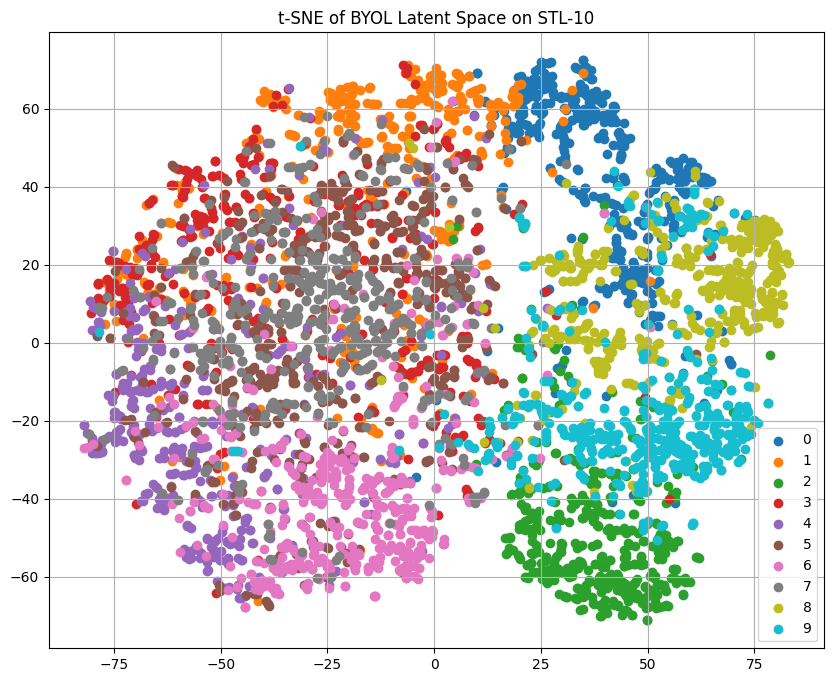

In [40]:
# t-sne
n_components = 2
random_seed = 0
perp = 15
fig = plt.figure(figsize=(30, 15))
x_tsne = TSNE(n_components, random_state=random_seed, perplexity=perp).fit_transform(encodings.data.cpu().numpy())
fig = plt.figure(figsize=(10 ,8))
ax = fig.add_subplot(1, 1, 1)
for i in np.unique(labels):
    ax.scatter(x_tsne[labels==i, 0], x_tsne[labels==i, 1], label=str(i))
ax.legend()
ax.grid()
ax.set_title("t-SNE of BYOL Latent Space on STL-10")

In [53]:
# repeat with the pre-trained backbone model
# load model
use_pretrained = True  # flag to load pre-trained ImageNet backbone weights, will use later
run_name = f'byol_cosine_pretrained_{use_pretrained}'
save_dir = os.path.join('./', run_name)
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
num_ftrs = backbone(torch.rand(1, 3, image_size, image_size)).view(-1).shape[-1]
model = BYOL(backbone, num_ftrs, hidden_dim, out_dim, batch_norm=True)
model.to(device)
model.eval()
_ = load_from_checkpoint(model, optimizer, device, save_dir=save_dir)

loaded model from checkpoint, resuming training from epoch 24


### t-SNE - BYOL with Pre-trained Backbone
---

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4864 but corresponding boolean dimension is 5000

<Figure size 3000x1500 with 0 Axes>

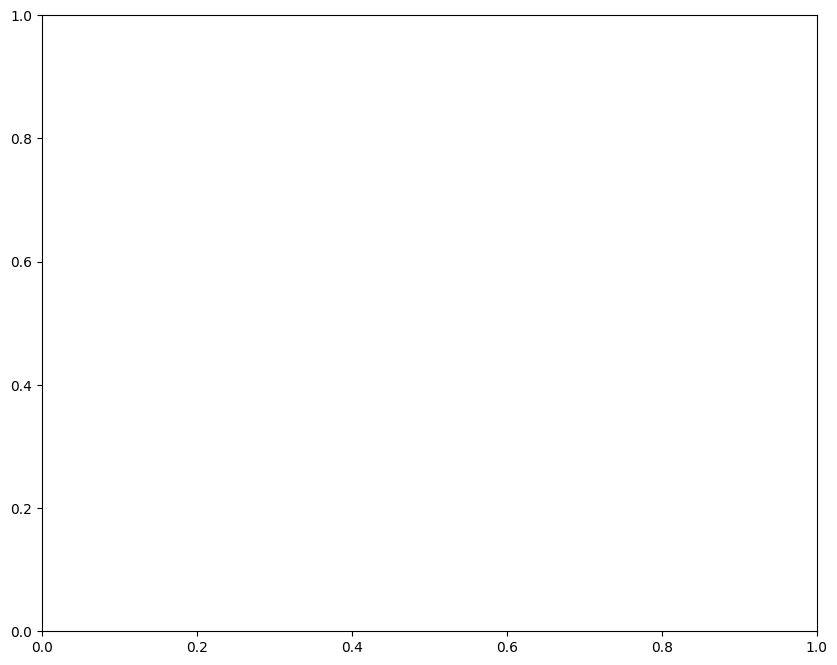

In [54]:
# TODO: t-sne plot for the model with the pre-trained backbone
# t-sne
n_components = 2
random_seed = 0
perp = 15
fig = plt.figure(figsize=(30, 15))
x_tsne = TSNE(n_components, random_state=random_seed, perplexity=perp).fit_transform(encodings.data.cpu().numpy())
fig = plt.figure(figsize=(10 ,8))
ax = fig.add_subplot(1, 1, 1)
for i in np.unique(labels):
    ax.scatter(x_tsne[labels==i, 0], x_tsne[labels==i, 1], label=str(i))
ax.legend()
ax.grid()
ax.set_title("t-SNE of BYOL Latent Space on STL-10 with pre-trained backbone")

## <img src="./assets/icons/code.png" style="height:50px;display:inline"> Task 7 - Using the Model for Linear Classification
---
* The standard benchmark to test the quality of self-supervised models is to extract represntations from the pre-trained model and train a linear classification model over these representations.
    * **Question 7.1**: Ideally, if the self-supervised model is perfect, then what should happen to the data in the low-dimensional space which would make it applicable for linear classification?
* Extract and collect the representations from the pre-trained model (with BatchNorm) for both the labeled training and test sets.
* Scale the data with `StandardScaler()`.
    * **Question 7.2**: Why is it important to scale the data before training?
* Train a linear clasisfication model (`LogisticRegression`, from `scikit-learn') to classify the data (cross-entropy). Check the performance on the test data.
* Repeat the process for the pre-trained model with the pre-trained backbone.
    * **Question 7.3**: Which model is better? Why?

In [41]:
train_ds = torchvision.datasets.STL10("./datasets/stl10", download=True, split="train", transform=transforms)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)

test_ds = torchvision.datasets.STL10("./datasets/stl10", download=True, split="test", transform=transforms)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


### Linear Classification - BYOL from Scratch
---

In [42]:
# load model
use_pretrained = True  # flag to load pre-trained ImageNet backbone weights, will use later
run_name = f'byol_cosine_pretrained_{use_pretrained}'
save_dir = os.path.join('./', run_name)
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
num_ftrs = backbone(torch.rand(1, 3, image_size, image_size)).view(-1).shape[-1]
model = BYOL(backbone, num_ftrs, hidden_dim, out_dim, batch_norm=True)
model.to(device)
_ = load_from_checkpoint(model, optimizer, device, save_dir=save_dir)
model.eval();

model checkpoint not found, training from scratch


In [43]:
# fitting a linear classifiers
# get all encodings for the train data
train_data = []
labels = []
for batch in train_dl:
    x = batch[0].to(device)
    labels.append(batch[1])
    with torch.no_grad():
        f = model.backbone(x).flatten(start_dim=1) # TODO: extract representation from the model
        z = f
        train_data.append(z)
train_data = torch.cat(train_data, dim=0)
labels = torch.cat(labels, dim=0)
print(train_data.shape)

torch.Size([5000, 512])


In [44]:
# get test data
test_data = []
labels_test = []
for batch in test_dl:
    x = batch[0].to(device)
    labels_test.append(batch[1])
    with torch.no_grad():
        f = model.backbone(x).flatten(start_dim=1) # TODO: extract representation from the model
        z = f
        test_data.append(z)
test_data = torch.cat(test_data, dim=0)
labels_test = torch.cat(labels_test, dim=0)
print(test_data.shape)

torch.Size([8000, 512])


In [46]:
# scale the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.data.cpu().numpy())# TODO
test_data_scaled = scaler.transform(test_data.data.cpu().numpy()) # TODO

In [47]:
# logistic regression classifier
random_state = 42
lin_cls = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=100000, multi_class="multinomial")

In [50]:
# fit linear classifier
lin_cls.fit(train_data_scaled, labels.data.cpu().numpy())  # TODO
lin_cls_pred = lin_cls.predict(train_data_scaled)  # TODO: prediction on training data
lin_cls_train_acc = accuracy_score(lin_cls_pred, labels.data.cpu().numpy())  # train accuracy
lin_cls_test_pred = lin_cls.predict(test_data_scaled)  # TODO: prediction on test data
lin_cls_test_acc = accuracy_score(lin_cls_test_pred, labels_test.data.cpu().numpy())  # test accuracy
print("train acc: {:.3f}, test acc: {:.3f}".format(lin_cls_train_acc, lin_cls_test_acc))

train acc: 0.675, test acc: 0.333


### Linear Classification - BYOL with Pre-trained Backbone
---

In [ ]:
# repeat for pre-trained backbone
# load model
use_pretrained = True  # flag to load pre-trained ImageNet backbone weights, will use later
run_name = f'byol_cosine_pretrained_{use_pretrained}'
save_dir = os.path.join('./', run_name)
# TODO: load model, extract train and test representations (same `train_dl` and `test_dl`), fit linear classifier
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
num_ftrs = backbone(torch.rand(1, 3, image_size, image_size)).view(-1).shape[-1]
model = BYOL(backbone, num_ftrs, hidden_dim, out_dim, batch_norm=True)
model.to(device)
_ = load_from_checkpoint(model, optimizer, device, save_dir=save_dir)
model.eval();


In [ ]:
# fitting a linear classifiers
# get all encodings for the train data
train_data = []
labels = []
for batch in train_dl:
    x = batch[0].to(device)
    labels.append(batch[1])
    with torch.no_grad():
        f = model.backbone(x).flatten(start_dim=1) # TODO: extract representation from the model
        z = f
        train_data.append(z)
train_data = torch.cat(train_data, dim=0)
labels = torch.cat(labels, dim=0)
print(train_data.shape)

torch.Size([5000, 512])


In [ ]:
# get test data
test_data = []
labels_test = []
for batch in test_dl:
    x = batch[0].to(device)
    labels_test.append(batch[1])
    with torch.no_grad():
        f = model.backbone(x).flatten(start_dim=1) # TODO: extract representation from the model
        z = f
        test_data.append(z)
test_data = torch.cat(test_data, dim=0)
labels_test = torch.cat(labels_test, dim=0)
print(test_data.shape)

torch.Size([8000, 512])


In [ ]:
# scale the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.data.cpu().numpy())# TODO
test_data_scaled = scaler.transform(test_data.data.cpu().numpy()) # TODO

In [ ]:
# logistic regression classifier
random_state = 42
lin_cls = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=100000, multi_class="multinomial")

In [ ]:
# fit linear classifier
lin_cls.fit(train_data_scaled, labels.data.cpu().numpy())  # TODO
lin_cls_pred = lin_cls.predict(train_data_scaled)  # TODO: prediction on training data
lin_cls_train_acc = accuracy_score(lin_cls_pred, labels.data.cpu().numpy())  # train accuracy
lin_cls_test_pred = lin_cls.predict(test_data_scaled)  # TODO: prediction on test data
lin_cls_test_acc = accuracy_score(lin_cls_test_pred, labels_test.data.cpu().numpy())  # test accuracy
print("train acc: {:.3f}, test acc: {:.3f}".format(lin_cls_train_acc, lin_cls_test_acc))

train acc: 0.675, test acc: 0.333


## <img src="./assets/icons/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com